In [15]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import surface_functions as sfun
import gudhi as gd

In [16]:


def find(parent, node):
    if parent[node] != node:
        parent[node] = find(parent, parent[node])
    return parent[node]

def union(parent, node1, node2):
    root1 = find(parent, node1)
    root2 = find(parent, node2)
    if root1 != root2:
        parent[root2] = root1

def build_contour_tree(Z):
    """
    Constructs a contour tree from a 2D scalar field represented by a 2D array Z.

    Parameters:
    Z (numpy.ndarray): A 2D array representing the scalar field.

    Returns:
    G (networkx.Graph): A graph representing the contour tree.
    contours (list): A list of root nodes in the contour tree.

    The contour tree is constructed by performing a depth-first search on the scalar field,
    connecting adjacent points with the same value into a contour. Each contour is represented
    as a connected component in the graph.
    """

    # Initialize an empty graph
    G = nx.Graph()

    # Generate a list of points in the scalar field
    points = [(i, j) for i in range(Z.shape[0]) for j in range(Z.shape[1])]

    # Sort the points based on their scalar values
    sorted_points = sorted(points, key=lambda p: Z[p])

    # Initialize a dictionary to store the parent of each point
    parent = {}

    # Initialize a set to store the root nodes of the contour tree
    contours = set()

    # Iterate over the sorted points
    for p in sorted_points:
        x, y = p
        current_parent = p

        # Check the neighbors of the current point
        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        for neighbor in neighbors:
            nex, ny = neighbor
            if 0 <= nex < Z.shape[0] and 0 <= ny < Z.shape[1] and neighbor in parent:
                neighbor_parent = find(parent, neighbor)
                if current_parent not in parent:
                    current_parent = neighbor_parent
                elif find(parent, current_parent) != neighbor_parent:
                    G.add_edge(find(parent, current_parent), neighbor_parent)
                    union(parent, current_parent, neighbor_parent)
                    contours.discard(find(parent, current_parent))
                    contours.add(neighbor_parent)

        # Assign the parent to the current point
        parent[p] = current_parent
        contours.add(find(parent, current_parent))

    # Return the contour tree graph and the root nodes
    return G, list(contours)

In [17]:
# Define the 2D grid
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)

# Define the elevation function
Z = sfun.himmelblau_function(X, Y)

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def build_contour_tree_NX(Z):
    G = nx.Graph()
    points = [(i, j) for i in range(Z.shape[0]) for j in range(Z.shape[1])]
    sorted_points = sorted(points, key=lambda p: Z[p])

    parent = {}
    contour_id = {}
    contours = set()
    next_id = 0

    for p in sorted_points:
        x, y = p
        current_parent = next_id
        next_id += 1

        # Check neighbors and determine the parent
        if x > 0 and (x-1, y) in parent:
            current_parent = contour_id[parent[(x-1, y)]]
        if y > 0 and (x, y-1) in parent:
            if (x-1, y) in parent and contour_id[parent[(x-1, y)]] != contour_id[parent[(x, y-1)]]:
                G.add_edge(contour_id[parent[(x-1, y)]], contour_id[parent[(x, y-1)]])
                merged_id = contour_id[parent[(x, y-1)]]
                parent_to_update = contour_id[parent[(x-1, y)]]
                for key, value in contour_id.items():
                    if value == parent_to_update:
                        contour_id[key] = merged_id
                contours.remove(parent_to_update)
            current_parent = contour_id[parent[(x, y-1)]]

        # Assign the parent to the current point
        parent[p] = p
        contour_id[p] = current_parent
        contours.add(current_parent)

    return G, list(contours)

In [19]:
#from contour_tree import build_contour_tree

contour_tree, contours = build_contour_tree(Z)

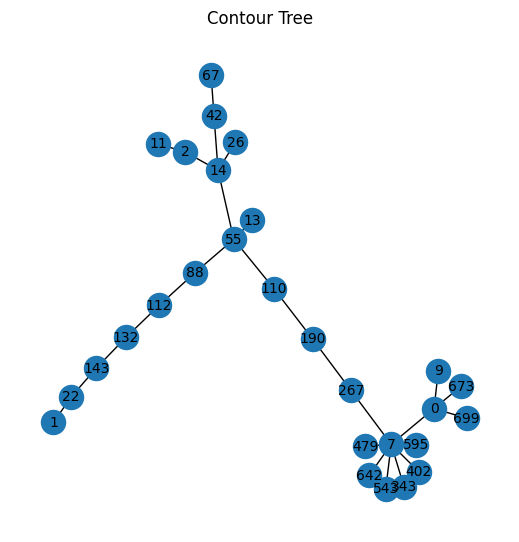

In [20]:
tree, ctrs = build_contour_tree_NX(Z)

pos = nx.spring_layout(tree)
plt.figure(figsize=(5, 5))
nx.draw(tree, pos, with_labels=True, node_size=300, font_size=10)
plt.title("Contour Tree")
plt.show()

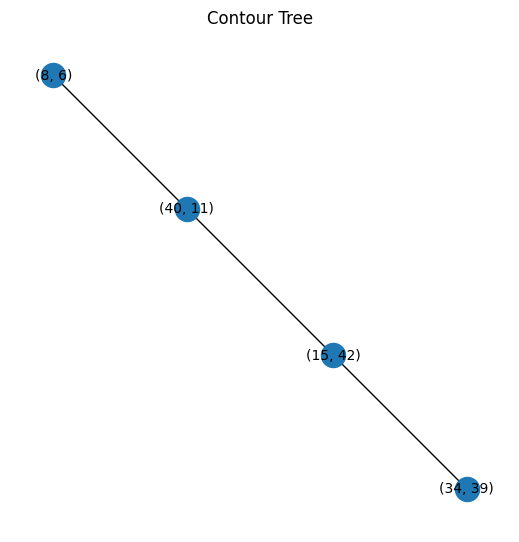

In [21]:

pos = nx.spring_layout(contour_tree)
plt.figure(figsize=(5, 5))
nx.draw(contour_tree, pos, with_labels=True, node_size=300, font_size=10)
plt.title("Contour Tree")
plt.show()

In [22]:
from simplex_tree import create_simplex_tree, create_simplex_tree_detailed

simplex_tree = create_simplex_tree(X, Z)
simplex_tree_optimized = create_simplex_tree_detailed(X, Z)

In [23]:
print(f"Dimension of the simplex tree:{simplex_tree.dimension()}")
print(f"Number of vertices: {simplex_tree.num_vertices()}")
print(f"Number of simplices: {simplex_tree.num_simplices()}")
print("============================================")
print(f"Dimension of the simplex tree:{simplex_tree_optimized.dimension()}")
print(f"Number of vertices: {simplex_tree_optimized.num_vertices()}")
print(f"Number of simplices: {simplex_tree_optimized.num_simplices()}")

Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 17004


In [24]:
# calculate persistance of the simplex tree
simplex_tree.initialize_filtration()
persistence = simplex_tree.persistence()
simplex_tree_optimized.initialize_filtration()
persistence_optimized = simplex_tree_optimized.persistence()

/tmp/ipykernel_15331/2324753987.py:2: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  simplex_tree.initialize_filtration()
/tmp/ipykernel_15331/2324753987.py:4: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  simplex_tree_optimized.initialize_filtration()


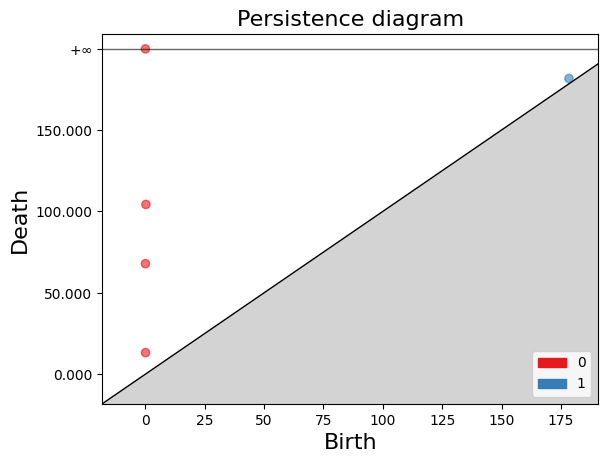

In [25]:
_ = gd.plot_persistence_diagram(persistence)
plt.show()

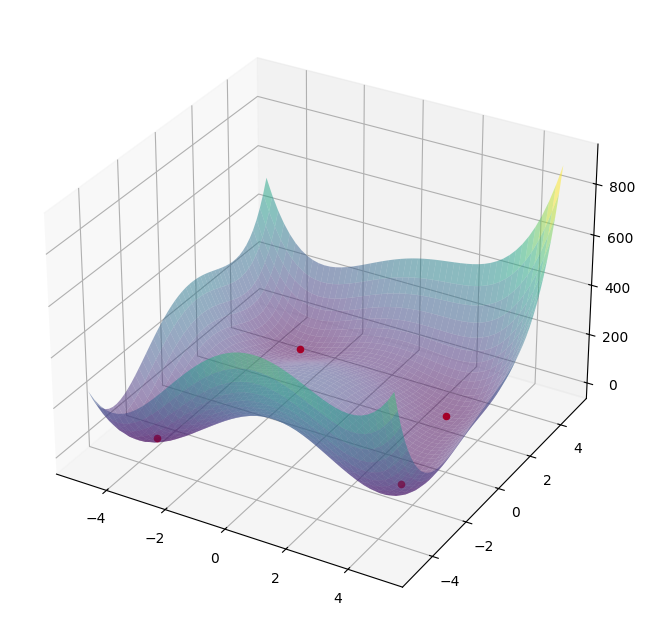

In [26]:
from visualization import plot_3d_surface

plot_3d_surface(X, Y, Z, contours)

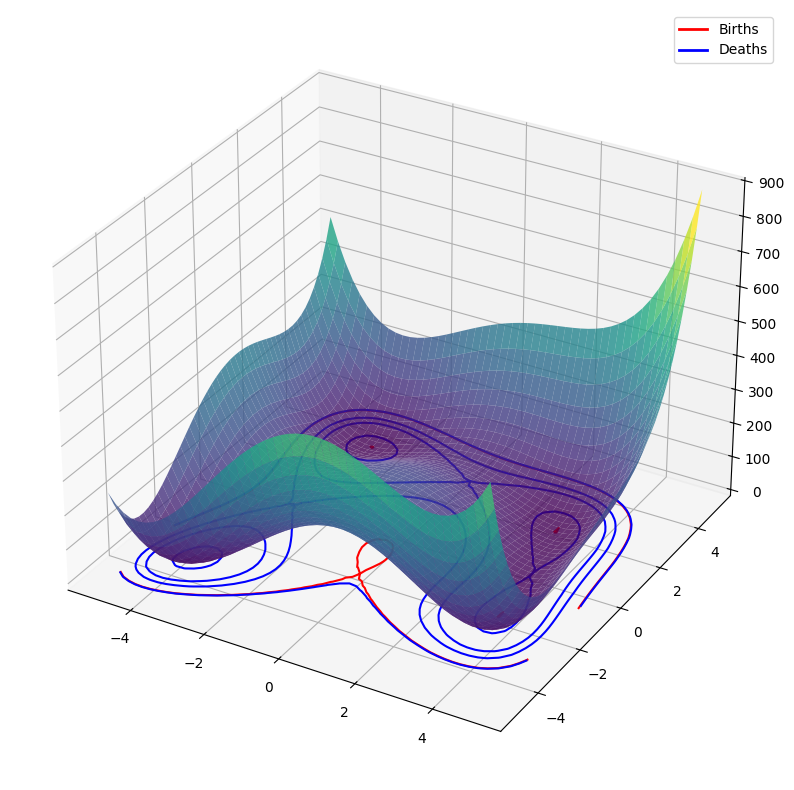

In [27]:
from matplotlib.lines import Line2D
# Extract significant features (based on persistence)
significant_features = [p for p in persistence if p[1][1] - p[1][0] > 0.1]

# Visualize the significant contours on the surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# Plot contours at significant birth and death levels
for dimension, (birth, death) in significant_features:
    ax.contour(X, Y, Z, levels=[birth], zdir='z', offset=-2, colors='r')
    ax.contour(X, Y, Z, levels=[death], zdir='z', offset=-2, colors='b')

legend_elements = [Line2D([0], [0], color='red', lw=2, label='Births'),
                   Line2D([0], [0], color='blue', lw=2, label='Deaths')]
plt.legend(handles=legend_elements, loc='best')
plt.show()

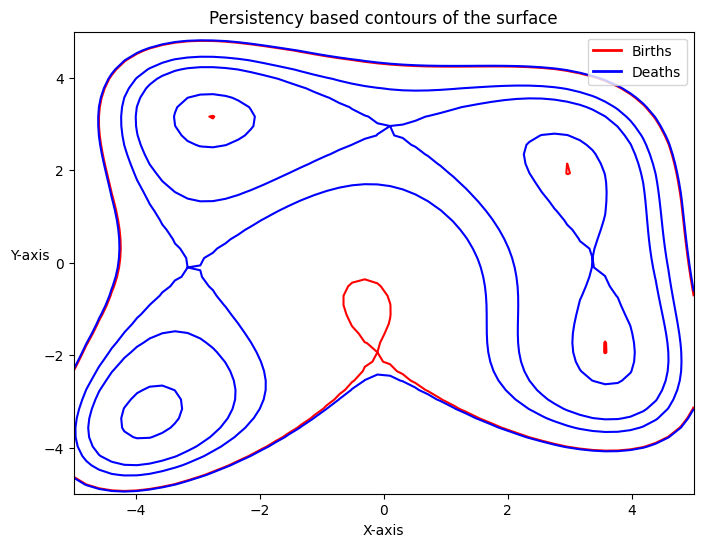

In [28]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
for dimension, (birth, death) in significant_features:
    ax.contour(X, Y, Z, levels=[birth], colors='r')
    ax.contour(X, Y, Z, levels=[death], colors='b' )

plt.title("Persistency based contours of the surface")
plt.xlabel("X-axis")
plt.ylabel("Y-axis", rotation=0, labelpad=10)

legend_elements = [Line2D([0], [0], color='red', lw=2, label='Births'),
                   Line2D([0], [0], color='blue', lw=2, label='Deaths')]
plt.legend(handles=legend_elements, loc='best')
plt.show()